# 목적
* 블로그 내용을 긁어와서 연관분석 진행
1. keyword관련 블로그 크롤링 
    정확도 기준으로 긁어오되 날짜도 같이 가져와서 나중 어떤 날짜에 집중되어 있는지 확인  
    한 블로그당 단어빈도수 분석(필요할까)
2. 블로그 내 단어 토크나이즈하고 
3. 연관분석실시


In [3]:
# # 선행설치
# !pip install beautifulsoup4
# !pip install requests
# !pip install lxm
# # 연관분석
# !pip install apyori
# # 자연어처리
# !pip install konlpy (JDK 설치가 되어있어야함 )

  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5984 sha256=5235bb621f4450c8a0ed214694dd194b7f3b0f6a4cf1cb568b9531188bd48e80
  Stored in directory: c:\users\try00\appdata\local\pip\cache\wheels\47\6f\0f\21a86f3679f7ed6bbe4dc6694f86818c5d85c2044bfab0f1e8
Successfully built apyori


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook  # 진행과정 시각화
from datetime import timedelta  # 시간날짜
from apyori import apriori  # 연관분석

import re
import json
import math
import datetime
from datetime import timedelta
import pandas as pd

import requests
import urllib.request
import urllib.error
import urllib.parse
from bs4 import BeautifulSoup  # 크롤링

import konlpy
from konlpy.tag import Komoran  # 자연어처리
komoran = Komoran(userdic='./user_dictionary.txt')

#한글깨짐방지
plt.rc('font',family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [42]:
def del_outword(string):
    '''
    이모티콘, \u200b과 같은 문자가 아닌 것 제거
    #이모티콘 제거 [출처](https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python)
    '''
    #이모지제거
    emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002702-\U000027B0"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)

    #분석에 어긋나는 불용어구 제외 (특수문자, 의성어)
    han = re.compile(r'[ㄱ-ㅎㅏ-ㅣ!?~,".\n\r#\ufeff\u200d\u200b\u2014]')
    add_pattern = re.compile(r'\u200b')
    string = emoji_pattern.sub(r'',string)
    string = han.sub(r'',string)
    string = add
    
    return string

In [43]:
def time_change(x):
    '''
    검색결과에 있는 문자를 날짜로 변경
    '''
    min_pattern = re.compile('[0-9]+'+"분 전")
    hour_pattern = re.compile('[0-9]+'+"시간 전")
    day_pattern = re.compile('[0-9]+'+"일 전")

    today = datetime.datetime.today().date()
    # 일자
    try:
        d = re.findall(day_pattern, x)[0][0]
        x = today - timedelta(days=int(d))
    except:
        pass
    # 시간
    try:
        d = re.findall(hour_pattern, x)[0]
        x = today
    except:
        pass
    # 분
    try:
        h = re.findall(min_pattern, x)[0]
        x = today
    except:
        pass

    if x == '어제':
        x = today - timedelta(days=1)

    elif type(x) == str:
        x = datetime.datetime.strptime(x.replace('.', '-')[:-1], '%Y-%m-%d')
    return x

In [44]:
def naver_blog_crawling(keyword, start_num=1, end_num=101,date_option=0,date_from='',date_to='',save = True):
    '''
    네이버 블로그 크롤링 함수
    네이버 블로그 검색결과를 크롤링하며, 1페이지당 10개씩을 검색한다
    
    keyword : string
     검색하고 싶은 키워드를 넣는다
     "keyword +필수어" 형태로 필수단어 추가 가능
    start_num : int (default = 1) 
     시작할 위치 1로 끝나는 단위 추천
    end_num : int (default = 101)
     끝나는 위치 1로 끝나는 단위 추천
    date_option : int (default = 0)
     주어지는 숫자에 의해 검색방법이 변경됨
     0 : 전체, 2 : 1일, 3 : 1주, 4 : 1개월, 6 : 6개월, 7 : 1년, 8 : 기간지정
    date_from : YYYYMMDD (default = "")
     date_option이 8일때 사용 검색 시작일자를 지정
    date_to : YYYMMDD (default = "")
     date_option이 8일때 사용 검색 마지막일자를 지정
    save : bool (default = True)
     csv로 저장 여부 결정
    '''
    #url 찾는 패턴
    pattern =re.compile('href="'+'[A-z0-9\:\/\&\;\.\?\=]+')

    #저장위치
    postdates = []
    strings = []
    urls = []
    titles = []
    output_error = []
    connection_error = []
    count = 1

    #keyword와 시작넘버만 바꾸면서 진행하게끔
    base_url = 'https://search.naver.com/search.naver?date_from={date_from}&date_option={date_option}&date_to={date_to}&dup_remove=1&nso=&post_blogurl=&post_blogurl_without=&query={keyword}&sm=tab_pge&srchby=all&st=sim&where=post&start={start}'

    #for문 돌려야하는 부분(각 검색결과의 시작은 1이고, 10개씩 보여짐,)
    for i in tqdm_notebook(range(start_num,end_num+1,10),desc = "page work"):
        search_list = base_url.format(keyword = keyword,start = i,
                                      date_option = date_option, date_from = date_from, date_to=date_to)
        response = requests.get(search_list)

        if response.status_code is 200:
            #1번 검색시 10개의 결과가 출력 따라서 section은 총 10개
            soup = BeautifulSoup(response.content,'lxml')
            sections = soup.findAll('li', attrs={'class':'sh_blog_top'})

            for section in sections:
                try:
                    #href부분만 가져오기 어려워서 정규표현식으로 검색
                    url = re.findall(pattern, str(section))[0].replace('?Redirect=Log&amp;logNo=','/').replace('href="','')
                    title = section.select_one('a.txt84').text
                    date = section.select_one('dd.txt_inline').text.strip()

                    #블로그 url안에 들어가기(아직 크롤링불가)
                    get_blog_post_content_code = requests.get(url)
                    get_blog_post_content_text = get_blog_post_content_code.text
                    get_blog_post_content_soup = BeautifulSoup(get_blog_post_content_text, 'lxml')

                    #크롤링가능한 url에 접속
                    real_blog_post_url = "http://blog.naver.com" + get_blog_post_content_soup.select('#mainFrame')[0].get('src')
                    get_real_blog_post_content_code = requests.get(real_blog_post_url)
                    get_real_blog_post_content_text = get_real_blog_post_content_code.text
                    get_real_blog_post_content_soup = BeautifulSoup(get_real_blog_post_content_text, 'lxml')

                    # url (에러나면 위에서부터 에러남)
                    urls.append(real_blog_post_url)
                    #블로그명
                    titles.append(title)
                    #날짜
                    postdates.append(date)

                    #본문  (postviewarea 패턴과 se-main-container 2가지 유형이 있어 분리함) 
                    try:
                        blog_post_content = get_real_blog_post_content_soup.select('div#postViewArea')
                        if len(blog_post_content) == 0:
                            blog_post_content = get_real_blog_post_content_soup.select('div.se-main-container')
                            if len(blog_post_content) == 0:
                                blog_post_content = get_real_blog_post_content_soup.select('div.se_component_wrap.sect_dsc.__se_component_area')
                            
                        string = ""
                        for sentence in blog_post_content[0].stripped_strings:
                            string += " "+sentence.replace('\xa0'," ")
                        strings.append([string])
                        count += 1
                    except:
                        strings.append(["X"])
                        count += 1

                except Exception as ex: 
#                     print('가져오기에러 {num}번째'.format(num = count),ex)
                    output_error.append(count)
                    count += 1
                    pass
        else:
#           print('연결오류 {num}번째'.format(num = count),response.status_code)
            connection_error.append(count)
            count += 1
                
    out_length = len(output_error+connection_error)
    print("검색한 길이:", end_num-start_num+10)
    print("제외된 길이:", out_length)
    print("검색된 길이:", end_num-start_num+10-out_length)
    crawling_df = pd.DataFrame(
        {"post_dates": postdates, "title": titles, "full_text": strings, "url": urls})
    crawling_df['post_dates'] = crawling_df['post_dates'].apply(lambda x : time_change(x))
    if save == True:
        crawling_df.to_csv(keyword+"_"+str(end_num)+'.csv',encoding = 'utf-8')
    return crawling_df, output_error

In [92]:
# keyword검색시 "검색어 +필수어" 형태로 필수단어 삽입가능
keyword = "수산 +양양"
start_num = 1
end_num = 1021
date_option = 0
date_from = ""
date_to = ""

In [93]:
crawling_df, output_error = naver_blog_crawling(keyword, start_num, end_num, date_option, date_from, date_to)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



검색한 길이: 1030
제외된 길이: 250
검색된 길이: 780


### 추출된 데이터 일자별 집중도 확인

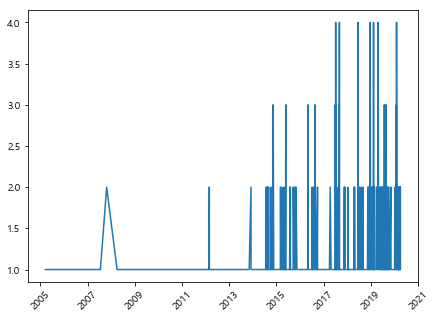

In [94]:
plt.figure(figsize=(7,5))
plt.plot(crawling_df['post_dates'].value_counts().sort_index())
plt.xticks(rotation = 45)
plt.savefig("./output/"+keyword+"_"+str(end_num)+'_날짜빈도'+'.png')
plt.show()

### 토크나이즈

In [95]:
#이후 함수화 해서 중복단어 없이 가져올지 말지 선택하면 될듯 
unique = True

komoran = Komoran(userdic='user_dictionary.txt')
sw = ['오늘','시간','최근','지난','관련','이번','이날','현재','10','올해','지난해','있다','이상','기준','때문',
     "메뉴","주문","강원도",'정도','도착','생각','양양군','사진','위치','양양']
all_nouns =[]

for i in tqdm_notebook(range(0,len(crawling_df))):
    try :
        nouns = komoran.nouns(crawling_df['full_text'][i][0])
    except :
        nouns = add_pattern.sub("",crawling_df['full_text'][i][0])
    clean_nouns = list(filter(lambda word : (len(word)>1)&(word not in sw),nouns))
    if unique == True:
        clean_nouns = list(set(clean_nouns))
    all_nouns.append(clean_nouns)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


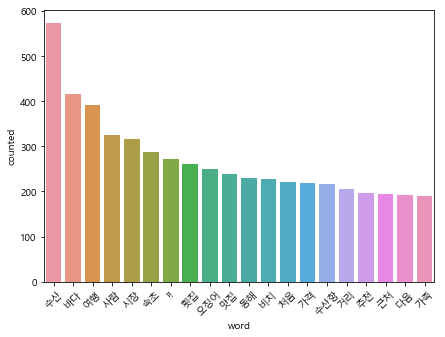

In [96]:
#2중리스트 flatten
all_noun_flatten = [y for x in all_nouns for y in x]

count_df = pd.Series(all_noun_flatten).value_counts().reset_index()

count_df.columns = ['word','counted']

plt.figure(figsize=(7,5))
sns.barplot(x= 'word', y = 'counted', data = count_df.head(20))
plt.xticks(rotation = 45)
#저장
count_df.to_csv("./output/"+keyword+"_"+str(end_num)+'_단어빈도'+'.csv',encoding ='cp949')
plt.savefig("./output/"+keyword+"_"+str(end_num)+'_단어빈도'+'.png')
plt.show()